In [46]:
'''
TO DO LIST:
1. Add function to convert between Hall mobility, Hall carrier concentration, and Hall factor
2. Mulitple Compounds Plot 
'''
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pandas as pd
import sys
import os

In [47]:
kB = 1.38e-23 # V / K
h = 6.626e-34 # J * s
hbar = 1.054e-34 # J * s

e = 1.602e-19 # C
me = 9.11e-31 # kg
Na = 6.02e23 # /mol

In [48]:
def read_STD2(fpath : str):
    df = pd.read_csv(fpath)
    return df


In [49]:
def reduced_df_by_sample(full_df, composition: str):
    comp_df = full_df.loc[full_df['composition'] == composition]
    return comp_df


In [50]:
def add_weighted_mobility(comp_df):
    S = comp_df['Seebeck coefficient'] #units of V/K
    rho = comp_df['Electrical resistivity'] #units of Ohm*m
    sigma = comp_df['Electrical conductivity']
    T = comp_df['Temperature'] #units of K
    rat = kB / e
    aS = np.abs(S)
    muW = 331 * (1e-5 / rho) * (T / 300)**(-3 / 2) * (np.exp(aS/rat - 2)\
                 /(1 + np.exp(-5 * (aS/rat -1))) + 3 * aS / (pi**2 * rat)\
                 /(1 + np.exp(5 * (aS/rat -1)))) 
    comp_df['Weighted mobility'] = muW
    return comp_df


In [51]:
def add_effective_mass(comp_df):
    S = comp_df['Seebeck coefficient'] #units of V/K
    rho = comp_df['Electrical resistivity'] #units of Ohm*m
    sigma = comp_df['Electrical conductivity']
    T = comp_df['Temperature'] #units of K
    nH = comp_df['Carrier concentration']
    rat = kB / e
    aS = np.abs(S)
    muS = (h**2/(2*kB*T))*(3*nH/16*pi**.5)**(2/3)* ((np.exp(aS/rat - 2)-0.17)**(2/3)\
                 /(1 + np.exp(-5 * (aS/rat -1))) + (3/pi**2)*(2/pi**0.5)**(2/3) * aS / (pi**2 * rat)\
                 /(1 + np.exp(5 * (aS/rat -1)))) 
    comp_df['Seebeck Effective Mass'] = muS/me
    return comp_df

In [52]:
def convert_hall_data(comp_df):
    # If carrier concentration doesn't exist and mobility exists, calculate carrier concentration
    if ( np.isnan(comp_df['Carrier concentration']).any() ) and ( not np.isnan(comp_df['Carrier mobility']).any() ):
        Rh = comp_df['Carrier mobility'].to_numpy() * comp_df['Electrical resistivity'].to_numpy()
        nh = (Rh * e) ** -1
        comp_df['Carrier concentration'] = nh
    
    # If mobility doesn't exist and carrier concentration exists, calculate mobility
    elif ( not np.isnan(comp_df['Carrier concentration']).any() ) and ( np.isnan(comp_df['Carrier mobility']).any() ):
        comp_df['Carrier mobility'] = (comp_df['Carrier concentration'].to_numpy() * comp_df['Electrical resistivity'].to_numpy() * e )**(-1)
    
    return comp_df

In [53]:
def split_sampleid(comp_df):
    sid = comp_df['sampleid'].to_numpy()
    unique_sampleid, sampleid_counts = np.unique(sid, return_counts=True)
    data = {}
    for sampleid in unique_sampleid:
        data[str(int(sampleid))] = comp_df.loc[comp_df['sampleid'] == sampleid]
    #print(data)
    return data


In [54]:
def merge_Hallmobility_columns(comp_df):
    for j in comp_df.index:
        if not pd.isna(comp_df['Hall movility'][j]):
            comp_df['Carrier mobility'][j] = comp_df['Hall movility'][j]
    comp_df.pop('Hall movility')
    return comp_df

[305. 310. 315. 320. 325. 330. 335. 340. 345. 350. 355. 360. 365. 370.
 375. 380.]


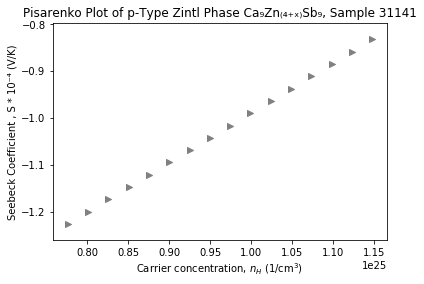

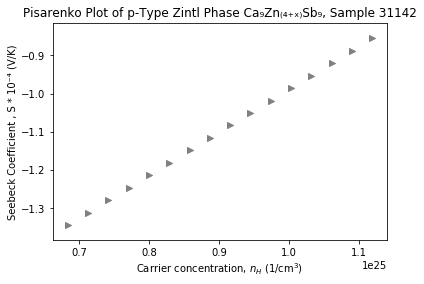

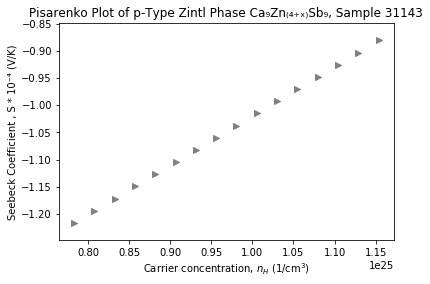

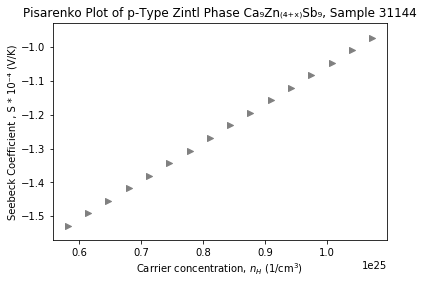

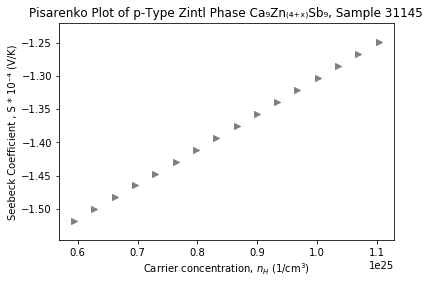

In [55]:
# Pisarenko Plots 
# S dec w/ nH dec cuz metal becomes more metallic 
# carr conc inc w/ T, S dec w/ T 
'''
Added by Ramya: Get list of sample IDs in the new_data
Note: be careful not to name variables "list" because this is
a keyword in Python that shouldn't be overwritten
'''
sid_list = list(new_data.keys()) #To understand this syntax, look up "python dictionaries"
T_list = new_data[sid_list[0]]['Temperature'].to_numpy()
print(T_list)
'''
for i in sid_list: 
    x10 = new_data[i]['Carrier concentration'].to_numpy() #units of V/K
    y10 = new_data[i]['Seebeck coefficient'].to_numpy() * 1e4 #units of Ohm*m
    plt.figure()
    plt.scatter(x10, y10, marker = '>', color = 'grey')
    plt.ylabel('Seebeck Coefficient , S * 10⁻⁴ (V/K)')
    plt.xlabel('Carrier concentration, $n_H$ (1/cm$^3$)')
    plt.title('Pisarenko Plot of p-Type Zintl Phase Ca₉Zn₍₄₊ₓ₎Sb₉, Sample {}'.format(i))
    
'''
# grab interploated data
# Ca Zn Sb compare 
# upwards slope weird - nh inc, S dec ()
# mult S in mV/K, mult by 1e6

In [56]:
def plot_mobility(comp_df):
    #Hall mobility plot
    plt.figure()
    plt.scatter(comp_df['Temperature'], comp_df['Carrier mobility'] * 1e4, color ='red', marker = '>')
    plt.ylabel(r'$\mu_H$ (cm$^2$/V/s)')
    plt.xlabel('Temperature (K)')
   
    #line style, while loop, xkcd 
    
    #Weighted mobility plot
    plt.figure()
    plt.scatter(comp_df['Temperature'], comp_df['Weighted mobility'])
    plt.ylabel(r'$\mu_W$ (cm$^2$/V/s)')
    plt.xlabel('Temperature (K)')
    
    #Combined Plot
   
    x = comp_df['Temperature']
    y1 = comp_df['Carrier mobility'] * 1e4
    y2 = comp_df['Weighted mobility']
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(x, y1, 'blue', marker = 'o', linewidth=0.5, markersize=2)
    ax2.plot(x, y2, 'green', marker = 'x', linewidth = 0.3, markersize=2)

    ax1.set_xlabel('Temperature (Kelvin)')
    ax1.set_ylabel('Hall Mobility, $\mu_H$ * 10$^4$ (cm$^2$/V/s)', color = 'blue')
    ax2.set_ylabel('Weighted Mobility, $\mu_W$ (cm$^2$/V/s) ', color = 'green')
    plt.title('Mobility Versus Temperature of Ca₉Zn₍₄₊ₓ₎Sb₉ ')
    plt.show()
   
    # Seebeck coeff versus cond 
    
    y3 = comp_df['Seebeck coefficient'] * 1e4 #units of V/K
    x2 = comp_df['Electrical conductivity'] #units of Ohm*m
    plt.figure()
    plt.scatter(x2, y3, marker = '*', color = 'indigo')
    plt.ylabel('Seebeck Coefficient, S (V/K)')
    plt.xlabel('Electrical Conductivity, \u03C3 (S/m)')
    
    #add pisarenko plot (S versus carrier conc nh)
    
    y4 = comp_df['Seebeck coefficient'] * 1e4 #units of V/K
    x3 = comp_df['Carrier concentration'] #units of Ohm*m
    plt.figure()
    plt.scatter(x3, y4, marker = '>', color = 'grey')
    plt.ylabel('Seebeck Coefficient, S (V/K)')
    plt.xlabel('Carrier concentration, $n_H$ (1/cm$^3$)')
    plt.title('Pisarenko Plot of p-Type Zintl Phase Ca₉Zn₍₄₊ₓ₎Sb₉')
    
  

/Users/alessandropereyra2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


undefined


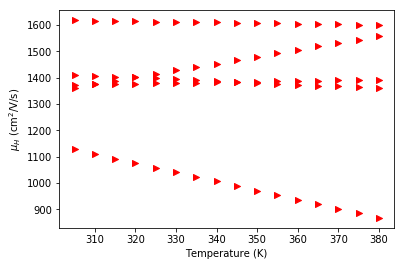

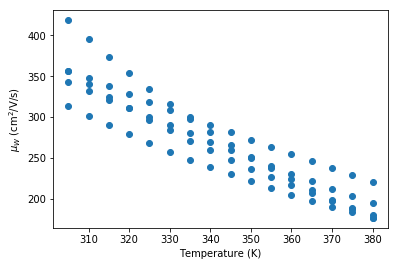

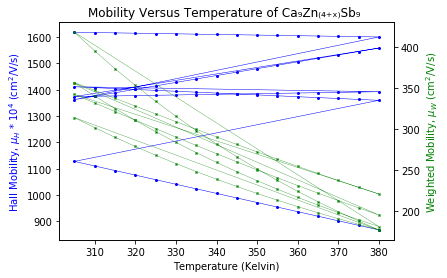

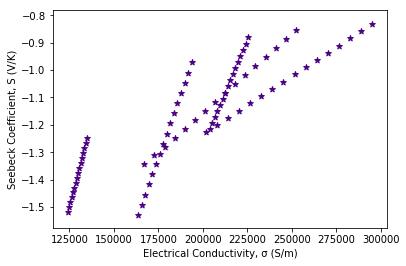

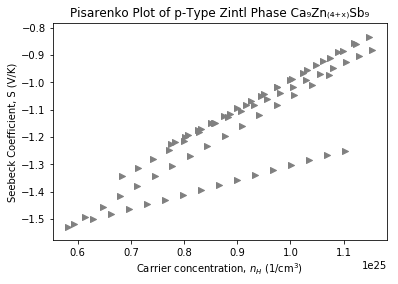

In [57]:
if __name__ == '__main__':
    #Provide path to the .csv file exported from sTarryData2
    full_df = read_STD2('csvfiles/ThermoTransSe10.10631.4870509.csv')
    #Dropping all rows that don't contain mobility data in either "Carrier mobility" or "Hall movility"
    if 'Hall movility' not in full_df.columns:
        full_df['Hall movility'] = np.nan #ad column of empty values
    elif 'Carrier mobility' not in full_df.columns:
        full_df['Carrier mobility'] = np.nan #ad column of empty values
    if 'Carrier concentration' not in full_df.columns:
        full_df['Carrier concentration'] = np.nan #ad column of empty values
    hall_df = full_df.dropna(how = 'all', subset = ['Hall movility','Carrier mobility', 'Carrier concentration'])
    for index,row in hall_df.iterrows():
        if row['Carrier concentration'] < 1e23 and row['Carrier concentration'] > 1e28: #m^-3
            hall_df.drop(index = index, inplace = True)
        if row['Thermal conductivity'] < 0.1 and row['Thermal conductivity'] > 50: #W/m/k
            hall_df.drop(index = index, inplace = True)
        if row['Electrical conductivity'] < 1e3 and row['Electrical conductivity'] > 1e7: #S/m
            hall_df.drop(index = index, inplace = True)
        if row['Seebeck coefficient'] < -1e-3 and row['Seebeck coefficient'] > 1e-3: #V/k
            hall_df.drop(index = index, inplace = True)
    #Drop any rows that don't contain both Seebeck and Conductivity data too
    hall_df = hall_df.dropna(how = 'any', subset = ['Seebeck coefficient', 'Electrical resistivity'])
    #Merge Hall mobility data from different columns
    hall_df = merge_Hallmobility_columns(hall_df)
    hall_df = convert_hall_data(hall_df)
    composition = hall_df['composition'][hall_df.index[0]] #Choosing first composition with Hall mobility data
    #Print composition
    print(composition)
    #Get dataframe for just the composition of interest
    comp_df = reduced_df_by_sample(hall_df, composition)
    #Add weighted mobility data
    comp_df = add_weighted_mobility(comp_df)
    #Plots of weighted mobility and Hall mobility
    plot_mobility(comp_df)
    # call effective mass, in terms of mass by e- (divide)
    comp_df = add_effective_mass(comp_df)
    mean = comp_df['Seebeck Effective Mass'].mean()
    #print(mean)
    stdev = comp_df['Seebeck Effective Mass'].std()
    #print(stdev)
    #print(comp_df['Seebeck Effective Mass'])
    new_data = split_sampleid(comp_df)

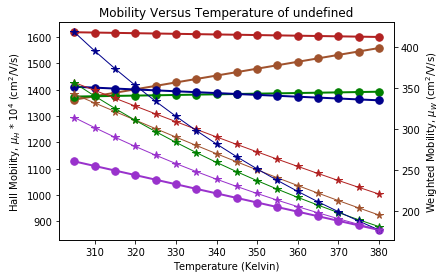

In [58]:
# HERE Weighted Mobility Plots (double axes)

#colors 
items = list(new_data.keys())
darkcol = ['firebrick', 'sienna', 'green', 'darkblue', 'darkorchid' ]
lightcol = ['salmon', 'tan', 'greenyellow', 'lightskyblue', 'thistle']
fig, ax4 = plt.subplots()
ax5 = ax4.twinx()

for i in range(len(items)): #range() function is quite useful for looping through the indices of a list
    x = new_data[items[i]]['Temperature'].to_numpy()
    a = new_data[items[i]]['Carrier mobility'].to_numpy() *1e4
    b = new_data[items[i]]['Weighted mobility'].to_numpy() 
    ax4.plot(x, a, darkcol[i % len(darkcol)], marker = 'o', linewidth = 2, markersize = 7.5) #May repeat colors
    ax5.plot(x, b, darkcol[i % len(darkcol)], marker = '*', linewidth = 1, markersize = 7.5)

    ax4.set_xlabel('Temperature (Kelvin)')
    ax4.set_ylabel('Hall Mobility, $\mu_H$ * 10$^4$ (cm$^2$/V/s)', color = 'black')
    ax5.set_ylabel('Weighted Mobility, $\mu_W$ (cm$^2$/V/s) ', color = 'black')
    plt.title('Mobility Versus Temperature of ' + composition)
plt.show()
    
# hall are warm colors
# weighted are cold 
# send plots for comments
# check trends, read paper (linearity)
# hall linear
#weighted curved 

In [59]:

#List of temperatures where there is data
T_array = new_data[sid_list[0]]['Temperature'].to_numpy()
index_list = list(new_data[sid_list[0]]['Temperature'].index)
print(T_array)
print(index_list)
'''
Create new dictionary with this structure:

'T' : {'n': [list of carrier concentrations], 'S': [list of Seebeck values]}
'''
prenko_dict = {}

for T in T_array:
    n = [] #carrier concentration
    S = [] #Seebeck coefficient
    Smass = [] #Seebeck effective mass
    for k in new_data.keys(): #This is looping through all the sampleIDs in new_data
        indx_list = new_data[k].index
        indx = indx_list[new_data[k]['Temperature'] == T]
        try:
            n.append(float(new_data[k]['Carrier concentration'][indx]))
            S.append(float(new_data[k]['Seebeck coefficient'][indx]))
            Smass.append(float(new_data[k]['Seebeck Effective Mass'][indx]))
        except:
            continue
    prenko_dict[str(T)] = {}
    prenko_dict[str(T)]['Carrier concentration'] = n
    prenko_dict[str(T)]['Seebeck coefficient'] = S
    prenko_dict[str(T)]['Seebeck Effective Mass'] = Smass

[305. 310. 315. 320. 325. 330. 335. 340. 345. 350. 355. 360. 365. 370.
 375. 380.]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [60]:
# Revised Pisarenko Plots

#List of temperatures where there is data
T_array = new_data[sid_list[0]]['Temperature'].to_numpy()
index_list = list(new_data[sid_list[0]]['Temperature'].index)
print(T_array)
print(index_list)
'''
Create new dictionary with this structure:

'T' : {'n': [list of carrier concentrations], 'S': [list of Seebeck values]}
'''
prenko_dict = {}

for T in T_array:
    n = [] #carrier concentration
    S = [] #Seebeck coefficient
    Smass = [] #Seebeck effective mass
    for k in new_data.keys(): #This is looping through all the sampleIDs in new_data
        indx_list = new_data[k].index
        indx = indx_list[new_data[k]['Temperature'] == T]
        try:
            n.append(float(new_data[k]['Carrier concentration'][indx]))
            S.append(float(new_data[k]['Seebeck coefficient'][indx]))
            Smass.append(float(new_data[k]['Seebeck Effective Mass'][indx]))
        except:
            continue
    prenko_dict[str(T)] = {}
    prenko_dict[str(T)]['Carrier concentration'] = n
    prenko_dict[str(T)]['Seebeck coefficient'] = S
    prenko_dict[str(T)]['Seebeck Effective Mass'] = Smass

[305. 310. 315. 320. 325. 330. 335. 340. 345. 350. 355. 360. 365. 370.
 375. 380.]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


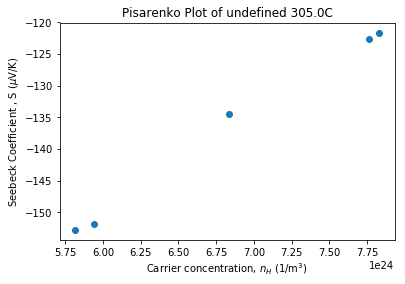

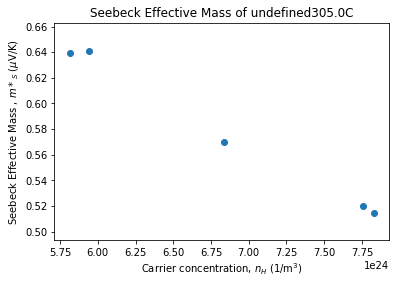

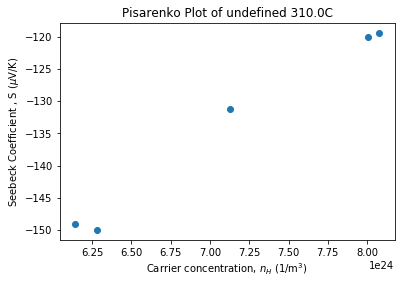

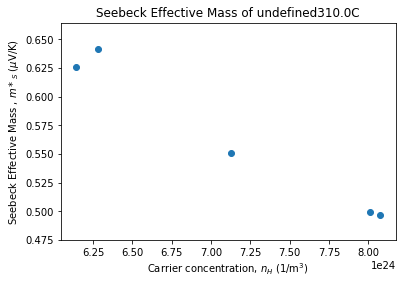

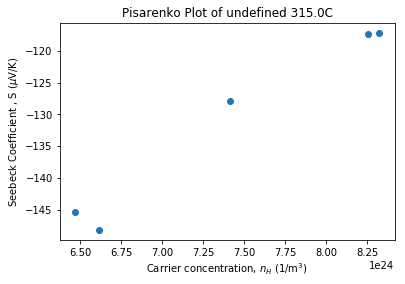

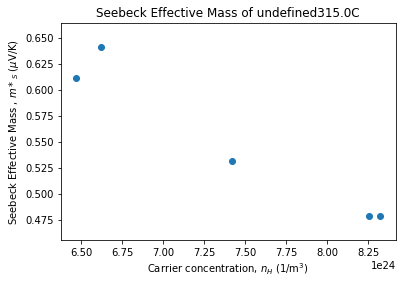

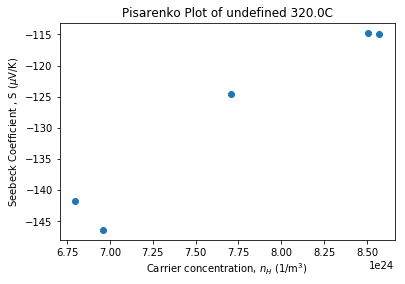

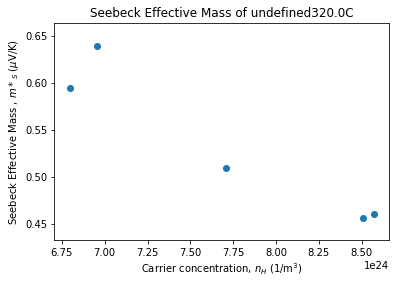

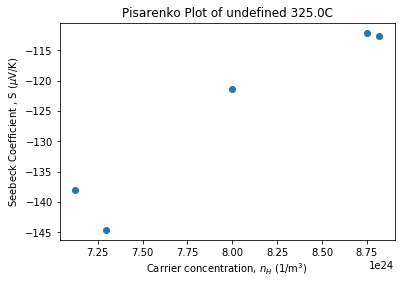

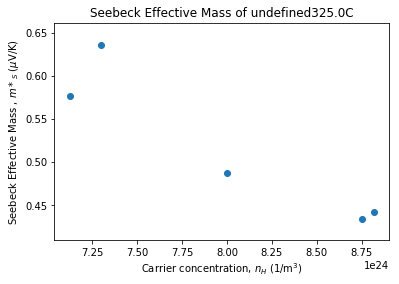

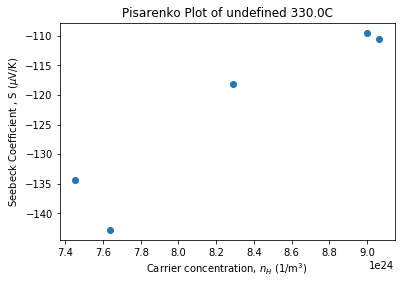

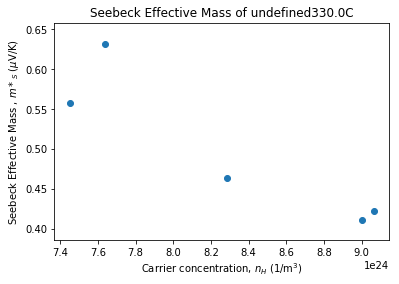

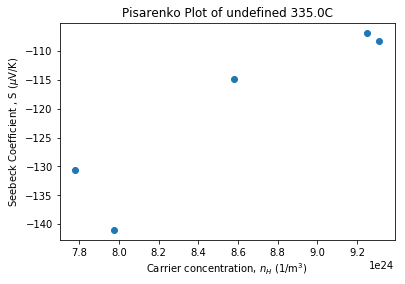

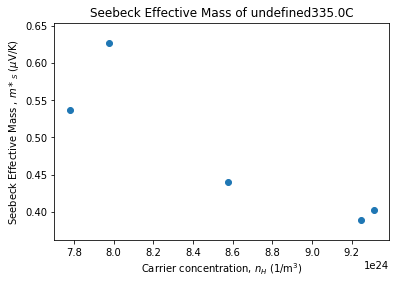

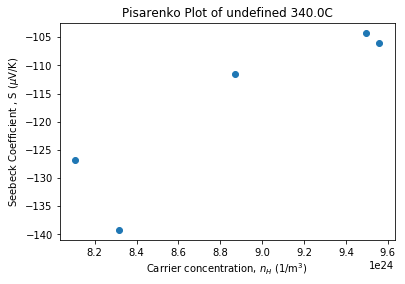

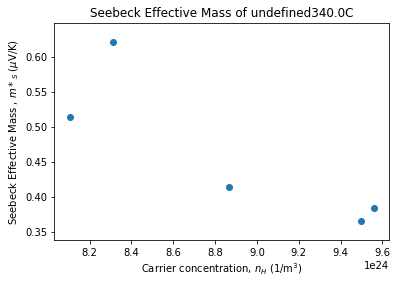

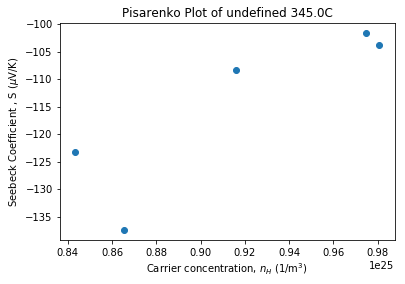

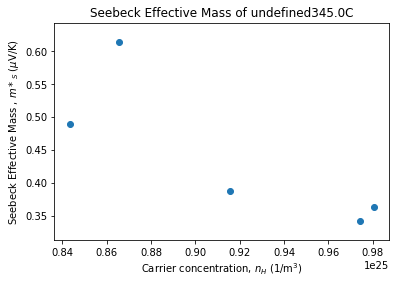

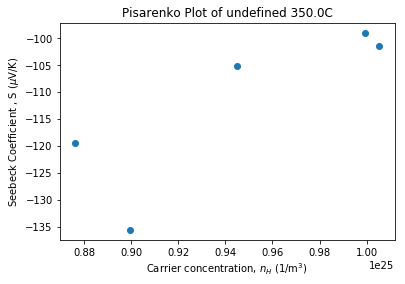

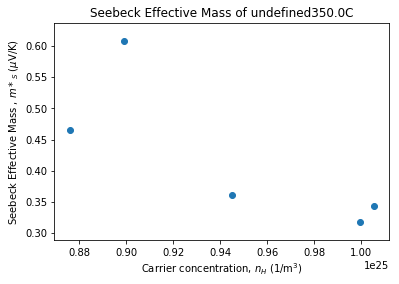

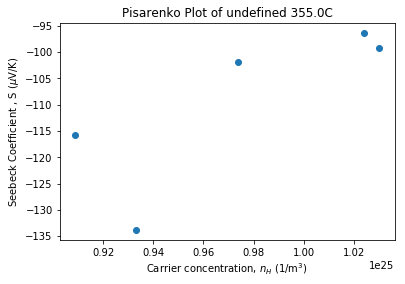

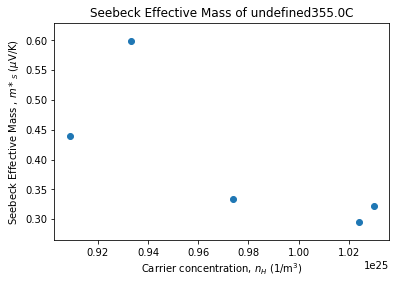

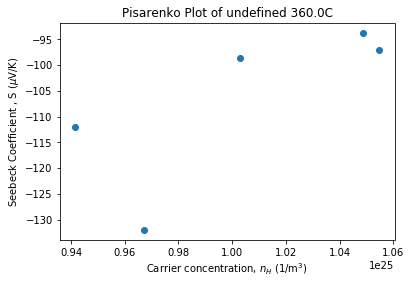

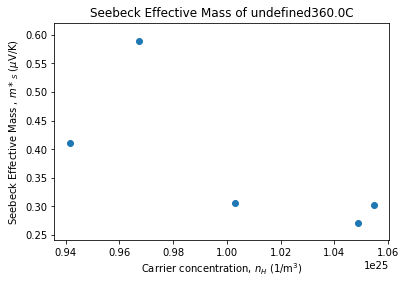

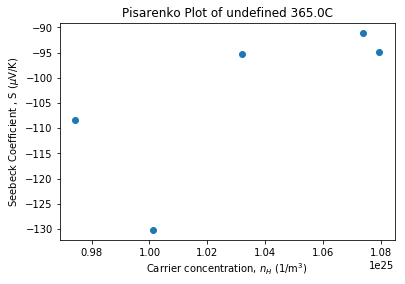

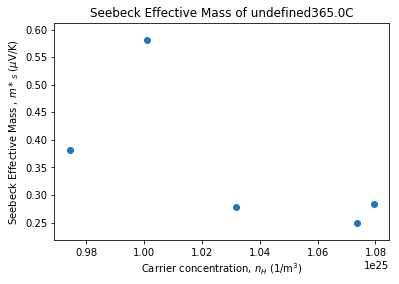

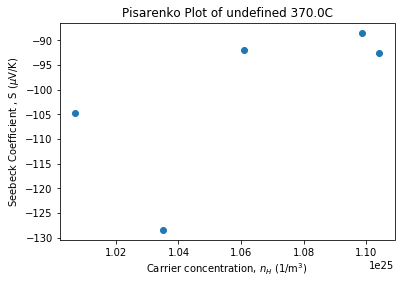

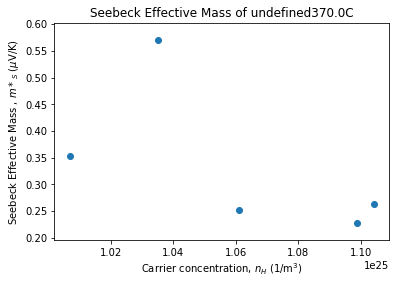

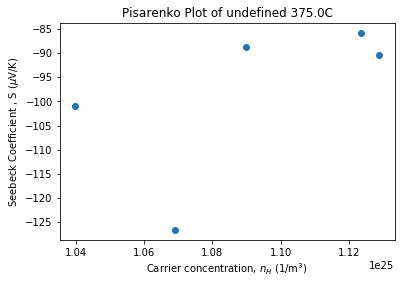

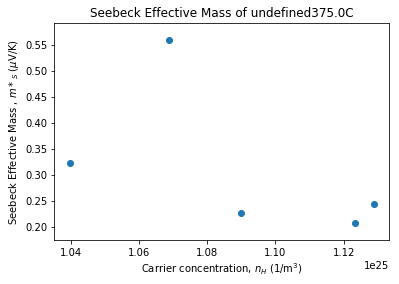

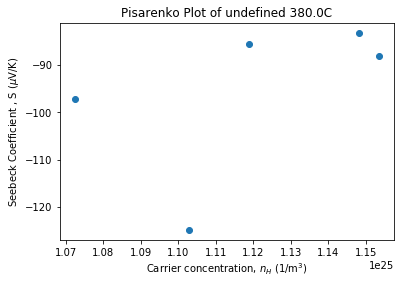

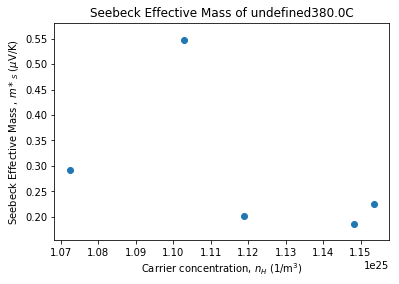

In [61]:
# HERE Plot Updated Pisarenkos

for k in prenko_dict.keys():
    plt.ylabel(r'Seebeck Coefficient , S ($\mu$V/K)')
    plt.xlabel('Carrier concentration, $n_H$ (1/m$^3$)')
    plt.title('Pisarenko Plot of ' + composition + ' ' + k + 'C') #update composition; do proper string formatting
    # Plots of Seebeck versus carrier concentration for each temperature
    plt.scatter(prenko_dict[k]['Carrier concentration'], np.array(prenko_dict[k]['Seebeck coefficient']) * 1e6)
    plt.show()
    #Plots of Seebeck eff. mass versus carrier concentration for each temperature
    plt.ylabel(r'Seebeck Effective Mass , $m*_S$ ($\mu$V/K)')
    plt.xlabel('Carrier concentration, $n_H$ (1/m$^3$)')
    plt.title('Seebeck Effective Mass of ' + composition + k + 'C')     
    plt.scatter(prenko_dict[k]['Carrier concentration'], prenko_dict[k]['Seebeck Effective Mass'])    
    plt.show()


In [ ]:
'''
MToriyama
Delete unnecessary data
'''
def Delete_Unnecessary_Data(df):
    new_df = df.copy()
    necessary_columns = [   "sampleid", \
                            "composition", \
                            "Temperature", \
                            "Carrier concentration", \
                            "Carrier mobility", \
                            "Electrical resistivity", \
                            "Seebeck coefficient", \
                            "Weighted mobility",
                            "Seebeck Effective Mass" ]
    for column in new_df.columns:
        if column not in necessary_columns:
            new_df = new_df.drop(columns=column)
    return new_df


In [ ]:
'''
MToriyama
General function to parse and clean dataframe.
What it does:
    1) Deletes any paper data that doesn't include any Hall data
    2) Completes any partial Hall data
    3) Calculates weighted mobility
    4) Calculates effective mass
Inputs:
    1) Panda dataframe
'''
def Refine_Data(raw_df):
    
    # Dropping all rows that don't contain mobility data in either "Carrier mobility" or "Hall movility"
    if 'Hall movility' not in raw_df.columns:
        raw_df['Hall movility'] = np.nan #ad column of empty values
    if 'Carrier mobility' not in raw_df.columns:
        raw_df['Carrier mobility'] = np.nan #ad column of empty values
    if 'Carrier concentration' not in raw_df.columns:
        raw_df['Carrier concentration'] = np.nan #ad column of empty values
    raw_df_with_hall = raw_df.dropna(how = 'all', subset = ['Hall movility', 'Carrier concentration'])
    raw_df_with_hall = raw_df.dropna(how = 'all', subset = ['Carrier mobility', 'Carrier concentration'])
    
    # Drop any rows that don't contain both Seebeck and Conductivity data too
    raw_df_with_hall = raw_df_with_hall.dropna(how = 'any', subset = ['Seebeck coefficient', 'Electrical resistivity'])
    
    # Merge Hall mobility data from different columns
    raw_df_with_hall = merge_Hallmobility_columns(raw_df_with_hall)
    raw_df_with_hall = convert_hall_data(raw_df_with_hall)
    
    # Add weighted mobility data
    raw_df_with_hall_WM = add_weighted_mobility(raw_df_with_hall)
    
    # call effective mass, in terms of mass by e- (divide)
    raw_df_with_hall_WM_EM = add_effective_mass(raw_df_with_hall_WM)
    
    return raw_df_with_hall_WM_EM

In [ ]:
'''
MToriyama
Function that reads through CSV files in a directory
What it does:
    1) Loops through CSV files in a given directory
    2) ...
Inputs:
    1) Directory name (as a string)
'''

def Parse_CSV_Files(csv_directory_name):
    for filename in os.listdir(csv_directory_name):
        if '.csv' not in filename:
            continue
        df = read_STD2(csv_directory_name+'/'+filename)
        refined_df = Delete_Unnecessary_Data( Refine_Data(df) ) # Optional, makes debugging easier
        print(refined_df)


# For example:
Parse_CSV_Files('csvfiles')



In [ ]:
#homework: run csv files, organize code with .py files, storing values into array, starting on big color plot 

In [ ]:
def fit_data(datafile, p0 = 1e6):
    '''
    Fit data to the Seebeck and conductivity data
    '''
    data_df = pd.read_csv(datafile)
    grps = data_df.groupby(by = [data_df.columns[1], data_df.columns[2]])
    split_comp = [grps.get_group(x) for x in grps.groups] #split by composition
    sig_df_list = []
    for data in split_comp: #loop over all compositions
        sig = data['Sigma (S/m)']
        S = data['S (V/K)']
        sigmaE0, cov = curve_fit(lambda s, sigmaE0 : conductivity_from_sige0(s, sigmaE0), S, sig,\
                            p0 = p0, bounds = (0.1, np.inf), method = 'dogbox')
        '''
            FOR ALESSANDRO:
            WHAT THE ABOVE LINE OF CODE DOES: Fits a value for sigmaE0 given input data (Seebeck) and output data (conductivity)
            lambda --> "lambda" functions in Python are just a different syntax for writing a function, and it works
            well with curve fit. Lots of resources on Google for "lambda" functions, but the general format is "lambda arguments : function"
            conductivity_from_sige0 --> a function that calculates conductivity when given a sigmaE0 value
            S, sig : Seebeck data and conductivity data
            p0 : initial guess for sigE0
            bounds : restricting sigE0 to be positive 
            method : just the minimization method used by PYthon, don't need to worry about this
        '''
        data['Sigma_E0'] = np.ones(len(sig)) * sigmaE0
        sig_df_list.append(data)
    return sig_df_list


In [ ]:
#effective mass is m_star
def fit_Seebeck_mass (S, m_star)
        nH = [((np.exp(aS/rat - 2)-0.17)**(2/3)\
                 /(1 + np.exp(-5 * (aS/rat -1))) + (3/pi**2)*(2/pi**0.5)**(2/3) * aS / (pi**2 * rat)\
                 /(1 + np.exp(5 * (aS/rat -1))))**(-1) * (h**2/(2*kB*T))**(-1)
                 * muS] ** (3/2) * (16*pi**.5)/3
        #I mostly did exponent -1 to invert the larger terms 
        #solve for nH (carrier conc)
        #takes s and m_star 
        
    comp_df['Seebeck Effective Mass'] = muS/me
    
    S = comp_df['Seebeck coefficient'] #units of V/K
    rho = comp_df['Electrical resistivity'] #units of Ohm*m
    sigma = comp_df['Electrical conductivity']
    T = comp_df['Temperature'] #units of K
    nH = comp_df['Carrier concentration']
    rat = kB / e
    aS = np.abs(S)